In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras

2026-01-03 21:54:44.314230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767477284.465023      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767477284.509332      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767477284.863690      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767477284.863750      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767477284.863756      24 computation_placer.cc:177] computation placer alr

## Loading Images

In [3]:
from tensorflow.keras.preprocessing.image import load_img 

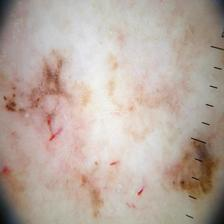

In [4]:
path = '/kaggle/input/skin-dataset/data/train/malignant'
name = '2.jpg'
fullname = path + '/' + name
load_img(fullname)

Usually we resize images. This is how a network will see these images:

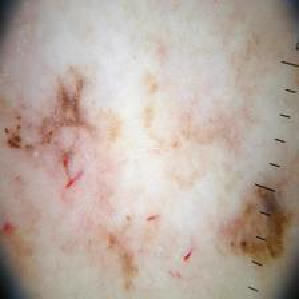

In [5]:
load_img(fullname, target_size=(299, 299))

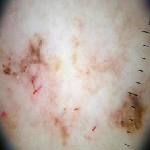

In [6]:
load_img(fullname, target_size=(150, 150))

## Pre-Trained Neural Network

Let's apply a pre-trained neural network with imagenet classes.

We'll use ResNet, but any other architecture will work as well.

Check here for a list of available models:

* https://keras.io/api/applications/
* https://www.tensorflow.org/api_docs/python/tf/keras/applications


We'll need to import 3 things:

* the model itself (`Xception`)
* the `preprocess_input` function that takes an image and prepares it
* the `decode_predictions` that converts the predictions of the model into human-readable classes

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions

Let's load the model. The pre-trained model expects 299x299 input

In [8]:
model = ResNet50(
    weights='imagenet',
    input_shape=(224, 224, 3)
)

I0000 00:00:1767477297.424251      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Next,

* we load the image using the `load_img` function
* convert it to a numpy array
* make it a batch of one example

In [9]:
img = load_img(fullname, target_size=(224, 224))
x = np.array(img)
x.shape

(224, 224, 3)

In [10]:
X = np.array([x])
X.shape

(1, 224, 224, 3)

We're ready!

Next, we will:

* prepare the input
* do the predictions
* convert the predictions into a human-readable format

In [11]:
X = preprocess_input(X)

In [12]:
pred = model.predict(X)

I0000 00:00:1767477305.612281      70 service.cc:152] XLA service 0x7ad308004e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767477305.612315      70 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1767477306.385413      70 cuda_dnn.cc:529] Loaded cuDNN version 91002


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


I0000 00:00:1767477308.853687      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [13]:
pred.shape

(1, 1000)

In [14]:
pred[0, :10]

array([1.36078515e-05, 2.96396727e-04, 1.42505616e-01, 1.90793537e-02,
       2.67663714e-03, 1.19561562e-02, 1.38734384e-02, 1.10433184e-05,
       3.70980451e-05, 5.28533419e-05], dtype=float32)

In [15]:
decode_predictions(pred)

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[[('n01484850', 'great_white_shark', np.float32(0.14250562)),
  ('n03920288', 'Petri_dish', np.float32(0.14159971)),
  ('n07734744', 'mushroom', np.float32(0.106266305)),
  ('n02219486', 'ant', np.float32(0.07031407)),
  ('n02799071', 'baseball', np.float32(0.06872797))]]

Not quite what we wanted... Let's train our own model

## Transfer learning

Instead of loading each image one-by-one, we can use a data generator. Keras will use it for loading the images and pre-processing them

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

We'll use smaller images - it'll be faster

In [17]:
image_size = (150, 150)
batch_size = 32

Let's get train data:

In [18]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    "/kaggle/input/skin-dataset/data/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 2637 images belonging to 2 classes.


And validation:

In [19]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    "/kaggle/input/skin-dataset/data/test",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 660 images belonging to 2 classes.


For fine-tuning, we'll use `Xception` with small images (150x150)

In [20]:
base_model = ResNet50(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False
)

base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Let's add a small neural net on top of that: just one layer with 10 neurons (there are 10 classes we want to predict)

In [21]:
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)
vector = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(2)(vector)

model = keras.Model(inputs, outputs)

Now we specify the learning rate and compile the model. After that, it's ready for training

In [22]:
learning_rate = 0.01

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

Let's train now for 10 epochs:

In [23]:
history = model.fit(train_ds, epochs=20, validation_data=test_ds)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 36s 314ms/step - accuracy: 0.7225 - loss: 1.5741 - val_accuracy: 0.8470 - val_loss: 0.5529
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.8300 - loss: 0.5675 - val_accuracy: 0.8485 - val_loss: 0.5138
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.8854 - loss: 0.3310 - val_accuracy: 0.8379 - val_loss: 0.5333
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.8833 - loss: 0.3613 - val_accuracy: 0.8545 - val_loss: 0.4986
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.8860 - loss: 0.3375 - val_accuracy: 0.8636 - val_loss: 0.6250
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9071 - loss: 0.2611 - val_accuracy: 0.8485 - val_loss: 0.7580
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.8953 - loss: 0.3428 - val_accuracy: 0.8591 - val_loss: 0.7701
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.9091 - loss: 0.3033 - val_accuracy: 0.8727 -

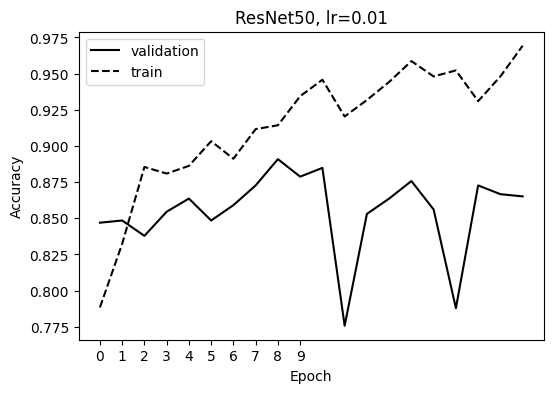

In [24]:
plt.figure(figsize=(6, 4))

epochs = history.epoch
val = history.history['val_accuracy']
train = history.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('ResNet50, lr=0.01')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(np.arange(10))

plt.legend()


plt.savefig('resnet_v1_0_01.svg')

plt.show()

0.01 is not necessarily the best learning rate, so we should experiment with 0.001 and 0.0001.

To make it easier for us, let's make a function for defining our model:

In [25]:
def make_model(learning_rate):
    base_model = ResNet50(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(2)(vector)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

Watching metrics this way is not convenient, so let's create a special callback for that

In [26]:
model = make_model(learning_rate=0.001)
history_0_001 = model.fit(train_ds, epochs=20, validation_data=test_ds)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 24s 187ms/step - accuracy: 0.7568 - loss: 0.5118 - val_accuracy: 0.8364 - val_loss: 0.3424
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.8567 - loss: 0.3306 - val_accuracy: 0.8576 - val_loss: 0.3085
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.8813 - loss: 0.2655 - val_accuracy: 0.8561 - val_loss: 0.3019
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.8994 - loss: 0.2369 - val_accuracy: 0.8652 - val_loss: 0.3236
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.9004 - loss: 0.2360 - val_accuracy: 0.8803 - val_loss: 0.2794
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.9128 - loss: 0.2082 - val_accuracy: 0.8833 - val_loss: 0.2881
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9109 - loss: 0.2031 - val_accuracy: 0.9015 - val_loss: 0.2765
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9263 - loss: 0.1818 - val_accuracy: 0.8773 -

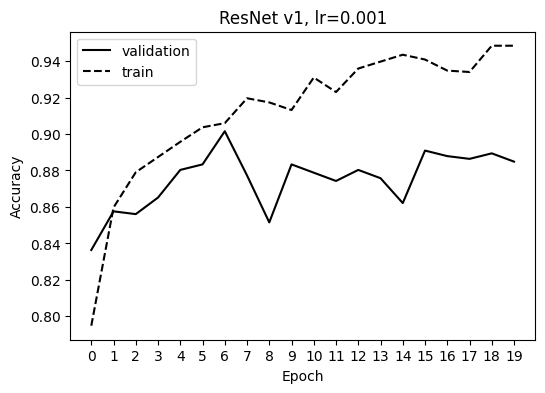

In [27]:
plt.figure(figsize=(6, 4))

epochs = history_0_001.epoch
val = history_0_001.history['val_accuracy']
train = history_0_001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('ResNet v1, lr=0.001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


plt.savefig('resnet_v1_0_001.svg')

plt.show()

In [28]:
model = make_model(learning_rate=0.0001)
history_0_0001 = model.fit(train_ds, epochs=20, validation_data=test_ds)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 24s 187ms/step - accuracy: 0.5760 - loss: 0.8059 - val_accuracy: 0.7409 - val_loss: 0.5492
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.7647 - loss: 0.5127 - val_accuracy: 0.7818 - val_loss: 0.4576
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.7995 - loss: 0.4400 - val_accuracy: 0.8030 - val_loss: 0.4158
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.8175 - loss: 0.4059 - val_accuracy: 0.8182 - val_loss: 0.3945
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.8386 - loss: 0.3787 - val_accuracy: 0.8288 - val_loss: 0.3786
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.8381 - loss: 0.3698 - val_accuracy: 0.8364 - val_loss: 0.3679
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.8563 - loss: 0.3342 - val_accuracy: 0.8424 - val_loss: 0.3610
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.8464 - loss: 0.3378 - val_accuracy: 0.8364 -

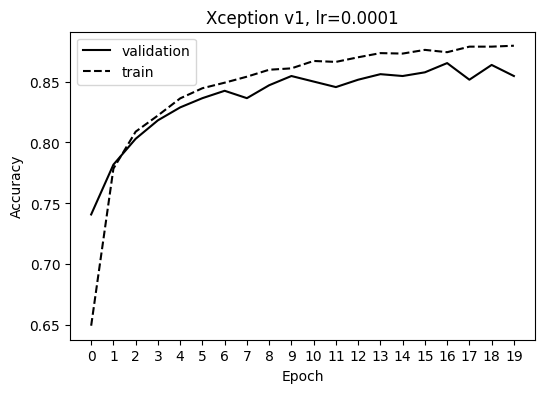

In [29]:
plt.figure(figsize=(6, 4))

epochs = history_0_0001.epoch
val = history_0_0001.history['val_accuracy']
train = history_0_0001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.0001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


plt.savefig('xception_v1_0_0001.svg')

plt.show()

In [30]:
epochs = np.arange(20)
val_0_01 = history.history['val_accuracy']
val_0_001 = history_0_001.history['val_accuracy']
val_0_0001 = history_0_0001.history['val_accuracy']

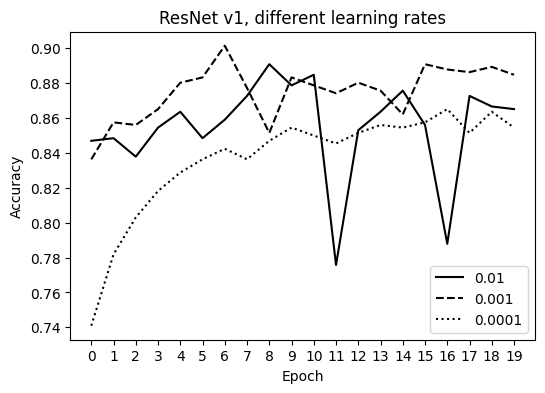

In [31]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val_0_01, color='black', linestyle='solid', label='0.01')
plt.plot(epochs, val_0_001, color='black', linestyle='dashed', label='0.001')
plt.plot(epochs, val_0_0001, color='black', linestyle='dotted', label='0.0001')


plt.title('ResNet v1, different learning rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()

plt.savefig('resnet_v1_all_lr.svg')

plt.show()

The best models:

* learning rate 0.01: 0.8713
* learning rate 0.001: 0.8770
* learning rate 0.0001: 0.8470

(your results may be slightly different)

To save the best model, we can use a callback. It'll monitor the accuracy, and if it's an improvement over the previous version, it'll save the model to disk

In [32]:
model = make_model(learning_rate=0.001)

In [33]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "ResNet_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_0_001 = model.fit(train_ds, epochs=10, validation_data=test_ds, callbacks=callbacks)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7040 - loss: 0.6150

83/83 ━━━━━━━━━━━━━━━━━━━━ 24s 188ms/step - accuracy: 0.7049 - loss: 0.6134 - val_accuracy: 0.8439 - val_loss: 0.3570
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8514 - loss: 0.3226

83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.8514 - loss: 0.3225 - val_accuracy: 0.8636 - val_loss: 0.3199
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8694 - loss: 0.2851

83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.8695 - loss: 0.2851 - val_accuracy: 0.8652 - val_loss: 0.3116
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8872 - loss: 0.2426

83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.8873 - loss: 0.2427 - val_accuracy: 0.8667 - val_loss: 0.3060
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8962 - loss: 0.2304

83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.8961 - loss: 0.2305 - val_accuracy: 0.8833 - val_loss: 0.2947
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.9147 - loss: 0.2121 - val_accuracy: 0.8682 - val_loss: 0.3046
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.9084 - loss: 0.2158 - val_accuracy: 0.8621 - val_loss: 0.2991
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.9172 - loss: 0.1869 - val_accuracy: 0.8561 - val_loss: 0.3508
Epoch 9/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.9309 - loss: 0.1820 - val_accuracy: 0.8652 - val_loss: 0.3157
Epoch 10/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.9347 - loss: 0.1726 - val_accuracy: 0.8833 - val_loss: 0.2865


Let's add one more layer - and a dropout between them

In [34]:
def make_model(learning_rate, droprate):
    base_model = ResNet50(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(2)(drop)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [35]:
model = make_model(learning_rate=0.001, droprate=0.0)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "ResNet_v2_0_0_{epoch:02d}_{val_accuracy:.3f}.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_0 = model.fit(train_ds, epochs=30, validation_data=test_ds, callbacks=callbacks)

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 25s 196ms/step - accuracy: 0.7170 - loss: 0.7837 - val_accuracy: 0.8652 - val_loss: 0.3050
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.8728 - loss: 0.2833 - val_accuracy: 0.8803 - val_loss: 0.2660
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.8953 - loss: 0.2282 - val_accuracy: 0.8894 - val_loss: 0.2565
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.9173 - loss: 0.1991 - val_accuracy: 0.8864 - val_loss: 0.2543
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.9283 - loss: 0.1755 - val_accuracy: 0.8803 - val_loss: 0.2997
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.9334 - loss: 0.1559 - val_accuracy: 0.8788 - val_loss: 0.2838
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9545 - loss: 0.1185 - val_accuracy: 0.8727 - val_loss: 0.2799
Epoch 8/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9519 - loss: 0.1282 - val_accuracy: 0.8803 -

In [36]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "ResNet_v2_0_2_{epoch:02d}_{val_accuracy:.3f}.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_1 = model.fit(train_ds, epochs=30, validation_data=test_ds, callbacks=callbacks)

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 212ms/step - accuracy: 0.7033 - loss: 0.7442 - val_accuracy: 0.8606 - val_loss: 0.3199
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.8510 - loss: 0.3020 - val_accuracy: 0.8803 - val_loss: 0.2685
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.8845 - loss: 0.2444 - val_accuracy: 0.8606 - val_loss: 0.3517
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.8879 - loss: 0.2480 - val_accuracy: 0.8667 - val_loss: 0.2739
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.9018 - loss: 0.2060 - val_accuracy: 0.8818 - val_loss: 0.2513
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.9161 - loss: 0.1845 - val_accuracy: 0.8788 - val_loss: 0.2839
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.9186 - loss: 0.1826 - val_accuracy: 0.8833 - val_loss: 0.2726
Epoch 8/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.9301 - loss: 0.1624 - val_accuracy: 0.8955 -

In [37]:
model = make_model(learning_rate=0.001, droprate=0.5)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "ResNet_v2_0_5_{epoch:02d}_{val_accuracy:.3f}.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_2 = model.fit(train_ds, epochs=30, validation_data=test_ds, callbacks=callbacks)

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 202ms/step - accuracy: 0.7212 - loss: 0.7291 - val_accuracy: 0.8591 - val_loss: 0.3185
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.8278 - loss: 0.3473 - val_accuracy: 0.8788 - val_loss: 0.2887
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.8604 - loss: 0.3080 - val_accuracy: 0.8652 - val_loss: 0.2906
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.8588 - loss: 0.2782 - val_accuracy: 0.8742 - val_loss: 0.2840
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.8856 - loss: 0.2544 - val_accuracy: 0.8864 - val_loss: 0.2750
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.8795 - loss: 0.2532 - val_accuracy: 0.8652 - val_loss: 0.2822
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.8826 - loss: 0.2533 - val_accuracy: 0.8712 - val_loss: 0.2920
Epoch 8/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.8958 - loss: 0.2268 - val_accuracy: 0.

In [38]:
model = make_model(learning_rate=0.001, droprate=0.8)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "ResNet_v2_0_8_{epoch:02d}_{val_accuracy:.3f}.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_3 = model.fit(train_ds, epochs=30, validation_data=test_ds, callbacks=callbacks)

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.6526 - loss: 1.0125 - val_accuracy: 0.8288 - val_loss: 0.3651
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.7604 - loss: 0.4684 - val_accuracy: 0.8576 - val_loss: 0.3272
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.7887 - loss: 0.4396 - val_accuracy: 0.8591 - val_loss: 0.3144
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.8004 - loss: 0.3979 - val_accuracy: 0.8348 - val_loss: 0.3357
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.8056 - loss: 0.3914 - val_accuracy: 0.8682 - val_loss: 0.2916
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.8435 - loss: 0.3408 - val_accuracy: 0.8697 - val_loss: 0.2982
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.8348 - loss: 0.3313 - val_accuracy: 0.8667 - val_loss: 0.2954
Epoch 8/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.8283 - loss: 0.3395 - val_accurac

In [39]:
epochs = np.arange(30)

train00 = history_0.history['accuracy']
train02 = history_1.history['accuracy']
train05 = history_2.history['accuracy']
train08 = history_3.history['accuracy']

val00 = history_0.history['val_accuracy']
val02 = history_1.history['val_accuracy']
val05 = history_2.history['val_accuracy']
val08 = history_3.history['val_accuracy']

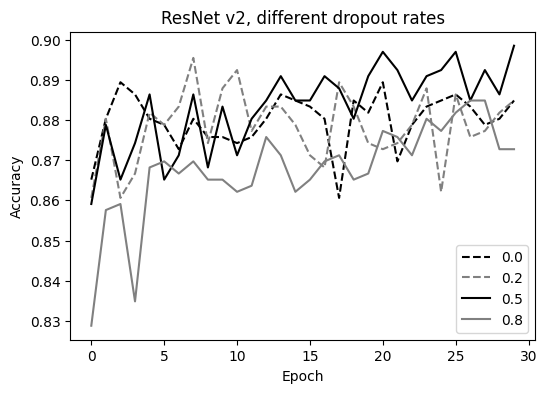

In [40]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, val02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, val05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, val08, color='grey', linestyle='solid', label='0.8')


plt.title('ResNet v2, different dropout rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('resnet_v2_dropout.svg')

plt.show()

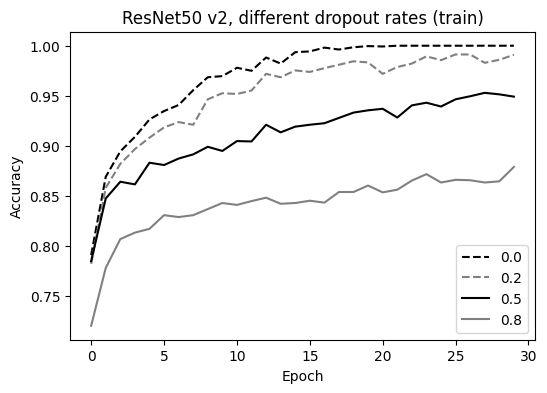

In [41]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, train00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, train02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, train05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, train08, color='grey', linestyle='solid', label='0.8')


plt.title('ResNet50 v2, different dropout rates (train)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('resnet50_v2_dropout_train.svg')

plt.show()

## Data augmentation

In [42]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "/kaggle/input/skin-dataset/data/test",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 660 images belonging to 2 classes.


In [43]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True,  
)

train_ds = train_gen.flow_from_directory(
    "/kaggle/input/skin-dataset/data/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 2637 images belonging to 2 classes.


In [44]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "ResNet_v3_{epoch:02d}_{val_accuracy:.3f}.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history = model.fit(train_ds, epochs=50, validation_data=test_ds, callbacks=callbacks)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 35s 311ms/step - accuracy: 0.7543 - loss: 0.5513 - val_accuracy: 0.8409 - val_loss: 0.3377
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 213ms/step - accuracy: 0.8409 - loss: 0.3326 - val_accuracy: 0.8682 - val_loss: 0.2934
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 222ms/step - accuracy: 0.8576 - loss: 0.2794 - val_accuracy: 0.8833 - val_loss: 0.2697
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 211ms/step - accuracy: 0.8816 - loss: 0.2477 - val_accuracy: 0.8788 - val_loss: 0.2734
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 234ms/step - accuracy: 0.9043 - loss: 0.2165 - val_accuracy: 0.8939 - val_loss: 0.2653
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 231ms/step - accuracy: 0.8846 - loss: 0.2410 - val_accuracy: 0.8833 - val_loss: 0.2726
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 223ms/step - accuracy: 0.9013 - loss: 0.2106 - val_accuracy: 0.8742 - val_loss: 0.2849
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 226ms/step - accuracy: 0.9091 - loss: 0.2172 - val_accu

In [45]:
epochs = history.epoch
accuracy = history.history['val_accuracy']

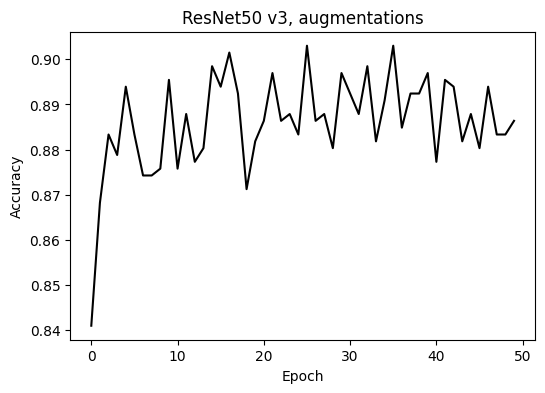

In [46]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, accuracy, color='black', linestyle='solid')


plt.title('ResNet50 v3, augmentations')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.savefig('ResNet50_v3_aug.svg')

plt.show()

## Larger model

In [47]:
def make_model(learning_rate, droprate):
    base_model = ResNet50(
        weights='imagenet',
        input_shape=(224, 224, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(2)(drop)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [48]:
image_size = (224, 224)
batch_size = 32

In [49]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True,  
)

train_ds = train_gen.flow_from_directory(
    "/kaggle/input/skin-dataset/data/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 2637 images belonging to 2 classes.


In [50]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    "/kaggle/input/skin-dataset/data/test",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 660 images belonging to 2 classes.


In [51]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "ResNet_v4_large_{epoch:02d}_{val_accuracy:.3f}.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_l = model.fit(train_ds, epochs=20, validation_data=test_ds, callbacks=callbacks)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 60s 579ms/step - accuracy: 0.7573 - loss: 0.5133 - val_accuracy: 0.8712 - val_loss: 0.3023
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 33s 395ms/step - accuracy: 0.8723 - loss: 0.2792 - val_accuracy: 0.8697 - val_loss: 0.2905
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 33s 394ms/step - accuracy: 0.8769 - loss: 0.2684 - val_accuracy: 0.8682 - val_loss: 0.2824
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 34s 405ms/step - accuracy: 0.8988 - loss: 0.2348 - val_accuracy: 0.8864 - val_loss: 0.3097
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 36s 434ms/step - accuracy: 0.8889 - loss: 0.2364 - val_accuracy: 0.8712 - val_loss: 0.3055
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 36s 432ms/step - accuracy: 0.8994 - loss: 0.2154 - val_accuracy: 0.8848 - val_loss: 0.2669
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 34s 407ms/step - accuracy: 0.9178 - loss: 0.2061 - val_accuracy: 0.8985 - val_loss: 0.2530
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 388ms/step - accuracy: 0.9022 - loss: 0.2046 - val_accu

Let's test these models now! (see another notebook)